In [1]:
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import geopandas as gpd
import imageio.v2 as imageio
import requests
import zipfile
import io
import os

load_dotenv(r"C:\Projects\storm_risk\.env")

engine = create_engine(
    "mysql+mysqlconnector://",
    connect_args={
        "host"    : os.getenv('MYSQL_HOST'),
        "user"    : os.getenv('MYSQL_USER'),
        "password": os.getenv('MYSQL_PASSWORD'),
        "database": os.getenv('MYSQL_DATABASE')
    }
)

print("✅ Connected!")

✅ Connected!


In [4]:
# Load county GeoJSON
geojson_url = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
counties_geojson = requests.get(geojson_url).json()

# Convert to GeoDataFrame
counties_gdf = gpd.GeoDataFrame.from_features(
    counties_geojson['features']
)

# Extract FIPS codes directly from features
fips_list = [f['id'] for f in counties_geojson['features']]
counties_gdf['fips_code'] = [str(f).zfill(5) for f in fips_list]

# Filter to continental US only
counties_gdf = counties_gdf.cx[-125:-65, 24:50]

print(f"Continental US counties loaded: {len(counties_gdf)}")

Continental US counties loaded: 3109


In [5]:
# Download Census Bureau states shapefile
states_url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip"
response   = requests.get(states_url)

# Extract from zip in memory
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall(r"C:\Projects\storm_risk\data\raw\states_shp")

# Load as GeoDataFrame
states_gdf = gpd.read_file(
    r"C:\Projects\storm_risk\data\raw\states_shp\cb_2020_us_state_20m.shp"
)

# Filter to continental US only
states_gdf = states_gdf[~states_gdf['STUSPS'].isin([
    'AK','HI','PR','VI','GU','MP','AS'
])]
states_gdf = states_gdf.cx[-125:-65, 24:50]

print(f"Continental US states loaded: {len(states_gdf)}")

Continental US states loaded: 49


In [6]:
# Pull all historical risk from MySQL
all_risk = pd.read_sql("""
    SELECT 
        fips_code,
        month,
        enhanced_risk
    FROM monthly_risk
    ORDER BY month ASC
""", engine)

# Extract month number (1-12)
all_risk['month_num'] = pd.to_datetime(all_risk['month'] + '-15').dt.month

# Average risk per county per calendar month across all years
monthly_avg = all_risk.groupby(
    ['fips_code', 'month_num']
).agg(
    enhanced_risk = ('enhanced_risk', 'mean')
).reset_index()

# For each county interpolate from 12 monthly values to 365 daily values
from scipy.interpolate import interp1d

all_counties = monthly_avg['fips_code'].unique()
day_of_year_records = []

# Representative day of year for each month (middle of month)
month_to_day = {1:15, 2:46, 3:74, 4:105, 5:135, 6:166,
                7:196, 8:227, 9:258, 10:288, 11:319, 12:349}

print(f"Interpolating 365 days for {len(all_counties)} counties...")

for fips in all_counties:
    county_data = monthly_avg[monthly_avg['fips_code'] == fips].copy()
    
    # Need at least 3 months of data to interpolate
    if len(county_data) < 3:
        continue
    
    # Get known days and risk values
    known_days   = [month_to_day[m] for m in county_data['month_num']]
    known_risk   = county_data['enhanced_risk'].values
    
    # Create interpolation function
    interp_func = interp1d(
        known_days, 
        known_risk, 
        kind='linear',
        bounds_error=False,
        fill_value=(known_risk[0], known_risk[-1])
    )
    
    # Generate value for all 365 days
    for day in range(1, 366):
        day_of_year_records.append({
            'fips_code'   : fips,
            'day_of_year' : day,
            'enhanced_risk': float(interp_func(day))
        })

day_of_year_risk = pd.DataFrame(day_of_year_records)

# Global min/max for consistent color scale
risk_min = day_of_year_risk['enhanced_risk'].min()
risk_max = day_of_year_risk['enhanced_risk'].max()
norm     = mcolors.Normalize(vmin=risk_min, vmax=risk_max)

print(f"Day of year records: {len(day_of_year_risk)}")
print(f"Unique days: {day_of_year_risk['day_of_year'].nunique()}")
print(f"Unique counties: {day_of_year_risk['fips_code'].nunique()}")
print(f"Risk range: {risk_min:.4f} to {risk_max:.4f}")

Interpolating 365 days for 3324 counties...
Day of year records: 1197200
Unique days: 365
Unique counties: 3280
Risk range: 0.6931 to 3.6109


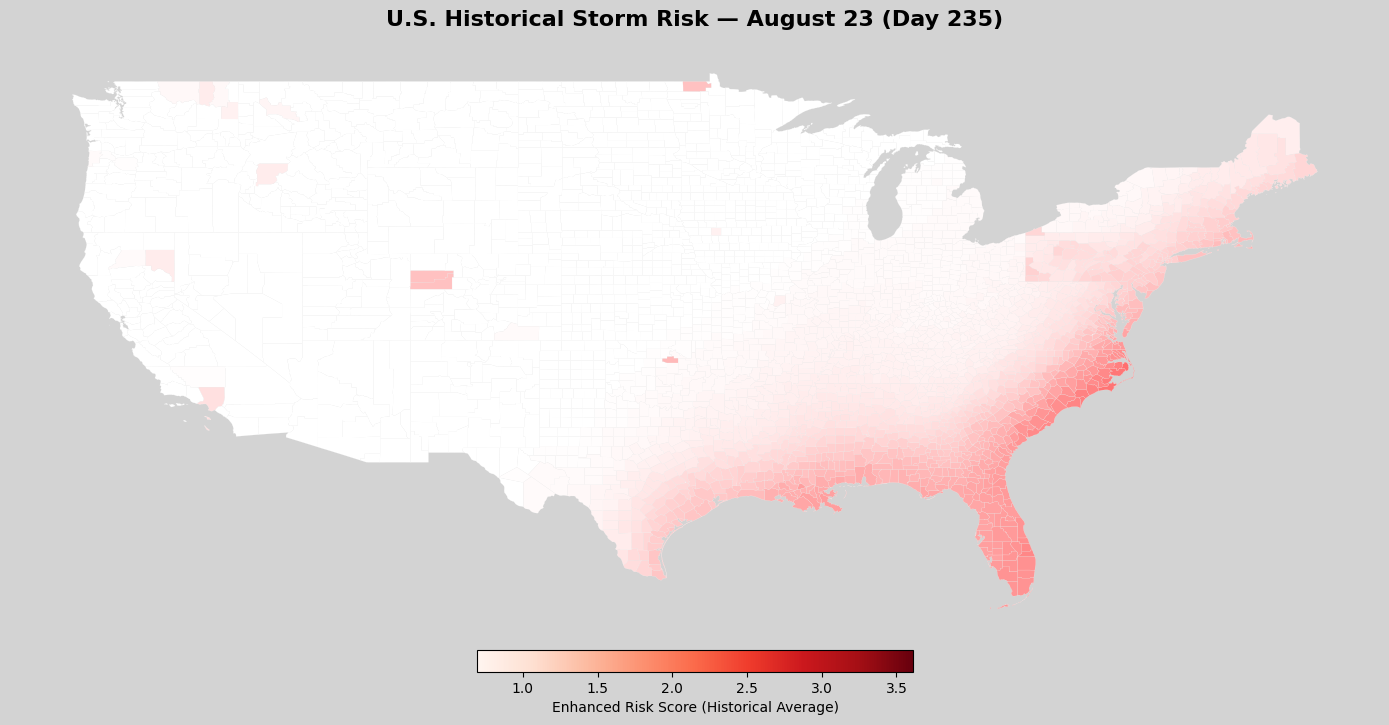

✅ Test frame saved!


In [9]:
from matplotlib.colors import LinearSegmentedColormap

# Test with day 235 = August 23rd - peak hurricane season
test_day = 235
day_data = day_of_year_risk[day_of_year_risk['day_of_year'] == test_day]

# Merge risk onto GeoDataFrame
frame_gdf = counties_gdf.merge(
    day_data[['fips_code','enhanced_risk']],
    on='fips_code',
    how='left'
)
frame_gdf['enhanced_risk'] = frame_gdf['enhanced_risk'].fillna(0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8), facecolor='lightgray')
ax.set_facecolor('lightgray')

# Custom colormap - white to bright vivid red
vivid_reds = LinearSegmentedColormap.from_list(
    'vivid_reds',
    ['#ffffff', '#ff6666', '#ff0000', '#cc0000', '#800000'],
    N=256
)

# Plot counties
frame_gdf.plot(
    column='enhanced_risk',
    ax=ax,
    cmap=vivid_reds,
    norm=norm,
    edgecolor='white',
    linewidth=0.1
)

# Title and formatting
ax.set_title(
    f'U.S. Historical Storm Risk — August 23 (Day {test_day})',
    fontsize=16, fontweight='bold', pad=15
)
ax.axis('off')

# Colorbar
sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='horizontal',
             fraction=0.03, pad=0.02,
             label='Enhanced Risk Score (Historical Average)')

plt.tight_layout()
plt.savefig(r'C:\Projects\storm_risk\outputs\test_frame_day235.png',
            dpi=100, bbox_inches='tight')
plt.show()

print("✅ Test frame saved!")

In [10]:
from matplotlib.colors import LinearSegmentedColormap

# Custom vivid red colormap
vivid_reds = LinearSegmentedColormap.from_list(
    'vivid_reds',
    ['#ffffff', '#ff6666', '#ff0000', '#cc0000', '#800000'],
    N=256
)

gif_path    = r'C:\Projects\storm_risk\outputs\storm_risk_dayofyear.gif'
temp_frames = []

print("Building 365 frames...")

for day in range(1, 366):
    # Get data for this day
    day_data  = day_of_year_risk[day_of_year_risk['day_of_year'] == day]
    
    # Convert day of year to readable date label
    date_label = pd.Timestamp('2024-01-01') + pd.Timedelta(days=day-1)
    date_str   = date_label.strftime('%B %d')

    # Merge risk onto GeoDataFrame
    frame_gdf  = counties_gdf.merge(
        day_data[['fips_code','enhanced_risk']],
        on='fips_code',
        how='left'
    )
    frame_gdf['enhanced_risk'] = frame_gdf['enhanced_risk'].fillna(0)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 8), facecolor='lightgray')
    ax.set_facecolor('lightgray')

    frame_gdf.plot(
        column='enhanced_risk',
        ax=ax,
        cmap=vivid_reds,
        norm=norm,
        edgecolor='white',
        linewidth=0.1
    )

    states_gdf.boundary.plot(
        ax=ax,
        color='white',
        linewidth=0.8
    )

    ax.set_title(
        f'U.S. Historical Storm Risk — {date_str} (Day {day})',
        fontsize=16, fontweight='bold', pad=15
    )
    ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap=vivid_reds, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, orientation='horizontal',
                 fraction=0.03, pad=0.02,
                 label='Enhanced Risk Score (Historical Average)')

    plt.tight_layout()

    temp_path = rf'C:\Projects\storm_risk\outputs\temp_frame_{day:03d}.png'
    plt.savefig(temp_path, dpi=80, bbox_inches='tight')
    temp_frames.append(temp_path)
    plt.close()

    if day % 50 == 0:
        print(f"  Frame {day} of 365 done — {date_str}")

print("\nStitching frames into GIF...")

with imageio.get_writer(gif_path, mode='I', duration=0.5, loop=0) as writer:
    for temp_path in temp_frames:
        image = imageio.imread(temp_path)
        writer.append_data(image)

# Clean up temp files
for temp_path in temp_frames:
    os.remove(temp_path)

size_mb = os.path.getsize(gif_path) / (1024 * 1024)
print(f"\n✅ GIF exported successfully!")
print(f"Location: {gif_path}")
print(f"File size: {size_mb:.1f} MB")
print(f"Frames: 365")

Building 365 frames...
  Frame 50 of 365 done — February 19
  Frame 100 of 365 done — April 09
  Frame 150 of 365 done — May 29
  Frame 200 of 365 done — July 18
  Frame 250 of 365 done — September 06
  Frame 300 of 365 done — October 26
  Frame 350 of 365 done — December 15

Stitching frames into GIF...

✅ GIF exported successfully!
Location: C:\Projects\storm_risk\outputs\storm_risk_dayofyear.gif
File size: 2.4 MB
Frames: 365


Showing historical storm risk for September 10 (Day 254 of year)

Top 10 highest risk counties on September 10:

       county_name state_name  enhanced_risk
       Dare County         NC       1.386290
           Unknown         NV       1.386290
   Carteret County         NC       1.356520
       Hyde County         NC       1.343620
    Pamlico County         NC       1.330890
New Hanover County         NC       1.308270
    Tyrrell County         NC       1.306640
           Unknown         KY       1.304002
     Onslow County         NC       1.291270
     Pender County         NC       1.287480


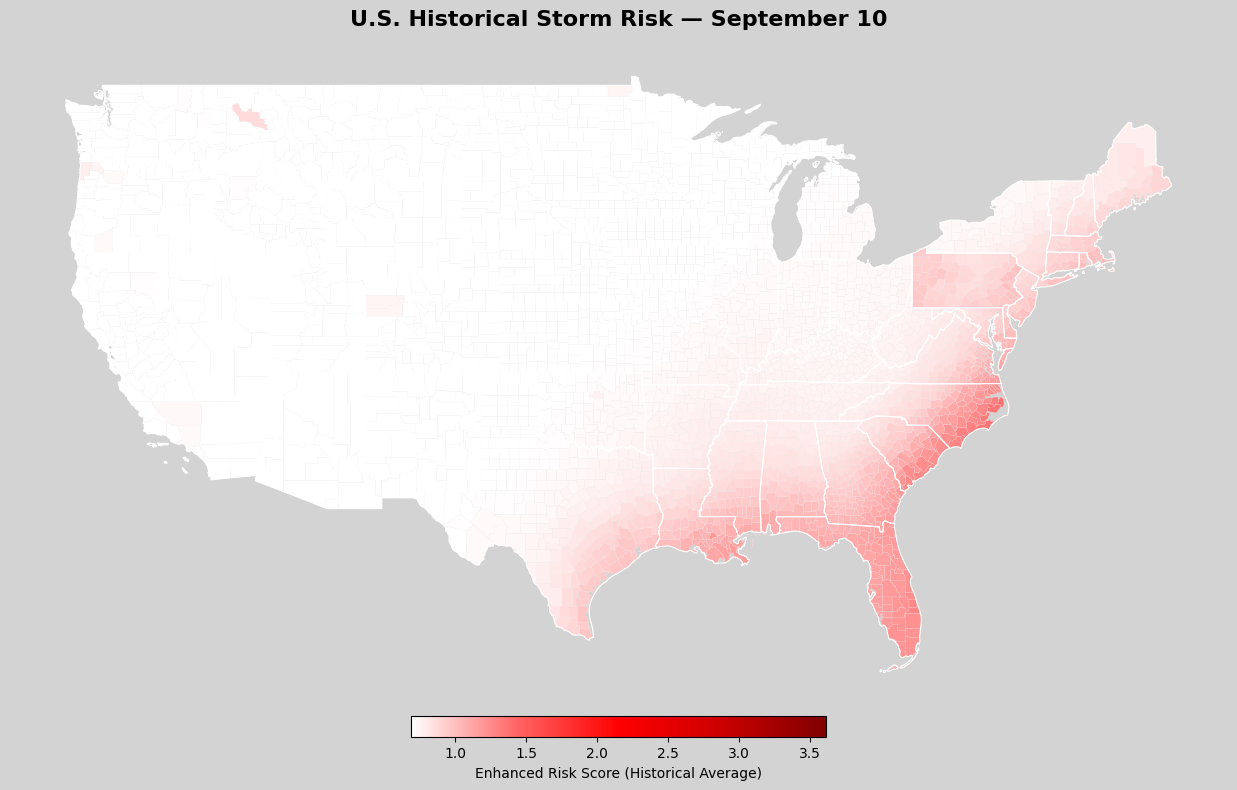


✅ Map saved to outputs folder as risk_09_10.png


In [14]:
# ================================================
# TYPE THE DAY AND MONTH YOU WANT TO CHECK
# ================================================
DAY   = 10
MONTH = 9
# ================================================

from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import matplotlib.pyplot as plt

# Custom vivid red colormap
vivid_reds = LinearSegmentedColormap.from_list(
    'vivid_reds',
    ['#ffffff', '#ff6666', '#ff0000', '#cc0000', '#800000'],
    N=256
)

# Build date label and day of year
date_label = pd.Timestamp(f'2024-{MONTH:02d}-{DAY:02d}').strftime('%B %d')
target_day = pd.Timestamp(f'2024-{MONTH:02d}-{DAY:02d}').dayofyear

print(f"Showing historical storm risk for {date_label} (Day {target_day} of year)")

# Get data for this day
day_data = day_of_year_risk[day_of_year_risk['day_of_year'] == target_day]

# Top 10 highest risk counties on this day
top10 = day_data.sort_values('enhanced_risk', ascending=False).head(10)
top10_named = top10.merge(
    pd.read_sql("SELECT fips_code, county_name, state_name FROM counties", engine),
    on='fips_code',
    how='left'
)

print(f"\nTop 10 highest risk counties on {date_label}:\n")
print(top10_named[['county_name','state_name','enhanced_risk']].to_string(index=False))

# Merge risk onto GeoDataFrame
frame_gdf = counties_gdf.merge(
    day_data[['fips_code','enhanced_risk']],
    on='fips_code',
    how='left'
)
frame_gdf['enhanced_risk'] = frame_gdf['enhanced_risk'].fillna(0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8), facecolor='lightgray')
ax.set_facecolor('lightgray')

frame_gdf.plot(
    column='enhanced_risk',
    ax=ax,
    cmap=vivid_reds,
    norm=norm,
    edgecolor='white',
    linewidth=0.1
)

states_gdf.boundary.plot(
    ax=ax,
    color='white',
    linewidth=0.8
)

ax.set_title(
    f'U.S. Historical Storm Risk — {date_label}',
    fontsize=16, fontweight='bold', pad=15
)
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap=vivid_reds, norm=norm)
sm.set_array([])
plt.colorbar(
    sm, ax=ax,
    orientation='horizontal',
    fraction=0.03, pad=0.02,
    label='Enhanced Risk Score (Historical Average)'
)

plt.tight_layout()
plt.savefig(
    rf'C:\Projects\storm_risk\outputs\risk_{MONTH:02d}_{DAY:02d}.png',
    dpi=120, bbox_inches='tight'
)
plt.show()

print(f"\n✅ Map saved to outputs folder as risk_{MONTH:02d}_{DAY:02d}.png")